In [1]:
using_colab = True
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

PyTorch version: 2.5.1+cu121
Torchvision version: 0.20.1+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/sam2.git to /tmp/pip-req-build-v1j38yc5
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam2.git /tmp/pip-req-build-v1j38yc5
  Resolved https://github.com/facebookresearch/sam2.git to commit 2b90b9f5ceec907a1c18123530e92e794ad901a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.3 MB/s eta 0:00:00
  Created wheel for SAM-2: filename=SAM_2-1.0-cp311-cp

In [2]:
!pip install mediapipe supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 13.3 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import mediapipe as mp

In [4]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [5]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import mediapipe as mp

In [6]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [7]:
video_dir = "/content/frames"
masks_dir = "/content/masks"
os.makedirs(video_dir, exist_ok=True)
os.makedirs(masks_dir, exist_ok=True)

In [8]:
video_dir = '/content/frames'
import supervision as sv
frames_generator = sv.get_video_frames_generator('/content/test.mp4')
sink = sv.ImageSink(
    target_dir_path='/content/frames/',
    image_name_pattern="{:05d}.jpeg")

with sink:
    for frame in frames_generator:
        sink.save_image(frame)

In [9]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 210/210 [00:10<00:00, 19.25it/s]


In [10]:
class HandMovementTracker:
    def __init__(self):
        self.mp_hands = mp.solutions.hands
        self.mp_drawing = mp.solutions.drawing_utils
        self.hands = self.mp_hands.Hands(
            static_image_mode=False,
            max_num_hands=2,
            min_detection_confidence=0.7
        )

        self.hand_movements = []

    def detect_hands(self, frame):
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = self.hands.process(rgb_frame)
        frame_movements = []

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                x_coordinates = [landmark.x for landmark in hand_landmarks.landmark]
                y_coordinates = [landmark.y for landmark in hand_landmarks.landmark]

                x_min, x_max = min(x_coordinates), max(x_coordinates)
                y_min, y_max = min(y_coordinates), max(y_coordinates)
                h, w, _ = frame.shape
                bbox = [
                    int(x_min * w),
                    int(y_min * h),
                    int(x_max * w),
                    int(y_max * h)
                ]

                frame_movements.append(bbox)
                cv2.rectangle(frame,
                    (bbox[0], bbox[1]),
                    (bbox[2], bbox[3]),
                    (0, 255, 0), 2
                )

        self.hand_movements.append(frame_movements)
        return frame

    def process_video(self, input_video_path, output_video_path):
        cap = cv2.VideoCapture(input_video_path)

        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        fps = cap.get(cv2.CAP_PROP_FPS)
        w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        out = cv2.VideoWriter(output_video_path, fourcc, fps, (w, h))

        self.hand_movements = []

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            processed_frame = self.detect_hands(frame)

            out.write(processed_frame)

        cap.release()
        out.release()

        return self.hand_movements


tracker = HandMovementTracker()
input_video = '/content/test.mp4'
output_video = '/content/hand_detection_output.mp4'

hand_movements = tracker.process_video(input_video, output_video)


In [11]:
bboxes = hand_movements[0]
box = bboxes[0]
center_x = (box[0] + box[2]) / 2
center_y = (box[1] + box[3]) / 2

points = np.array([[center_x, center_y]], dtype=np.float32)
points

array([[590.5, 266.5]], dtype=float32)

In [12]:
bboxes = hand_movements[1]
box = bboxes[1]

center_x = (box[0] + box[2]) / 2
center_y = (box[1] + box[3]) / 2

points = np.array([[center_x, center_y]], dtype=np.float32)
points

array([[776.5, 372. ]], dtype=float32)

In [13]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

In [14]:
prompts = {}

In [15]:
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

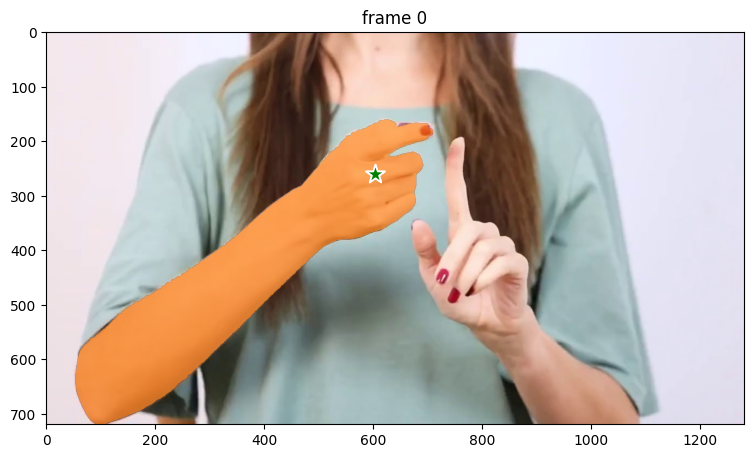

In [16]:
ann_frame_idx = 0
ann_obj_id = 1

points = np.array([[603.5, 261.]], dtype=np.float32)

labels = np.array([1], np.int32)
prompts[ann_obj_id] = points, labels
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
for i, out_obj_id in enumerate(out_obj_ids):
    show_points(*prompts[out_obj_id], plt.gca())
    show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

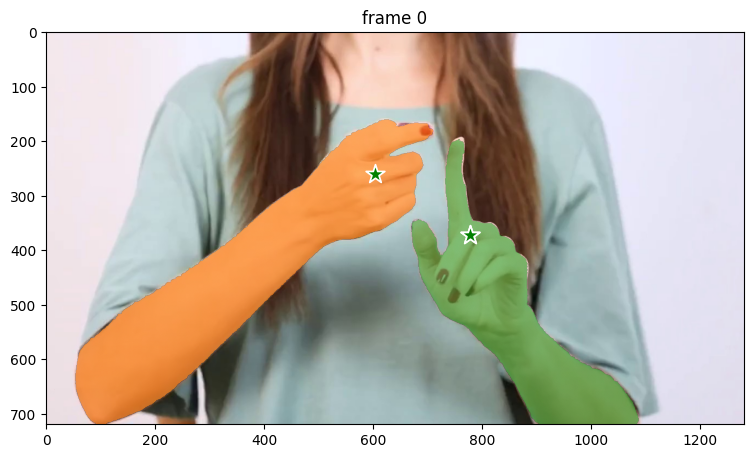

In [17]:
ann_frame_idx = 0
ann_obj_id = 2

points = np.array([[777.5, 372.5]], dtype=np.float32)

labels = np.array([1], np.int32)
prompts[ann_obj_id] = points, labels
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
for i, out_obj_id in enumerate(out_obj_ids):
    show_points(*prompts[out_obj_id], plt.gca())
    show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

propagate in video: 100%|██████████| 210/210 [04:58<00:00,  1.42s/it]


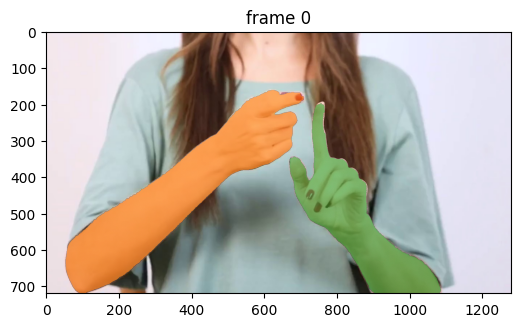

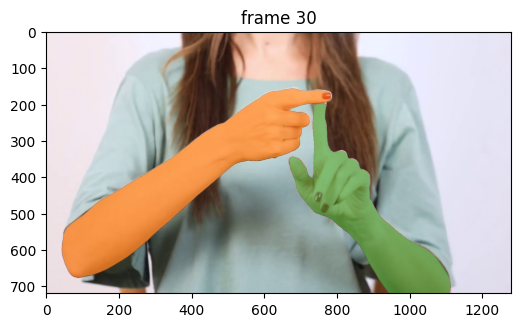

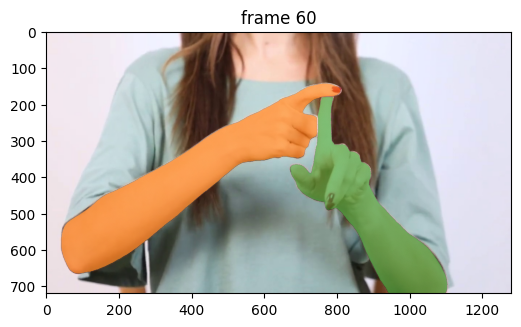

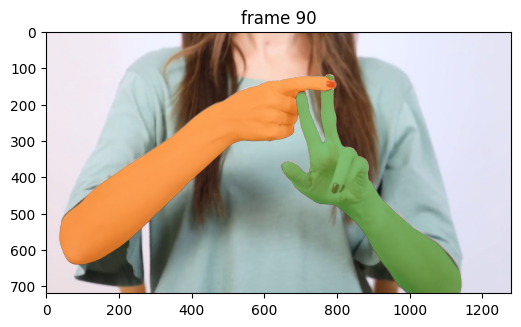

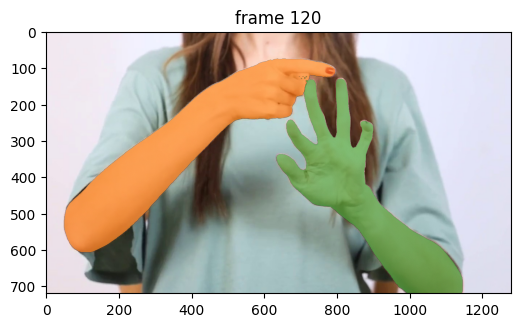

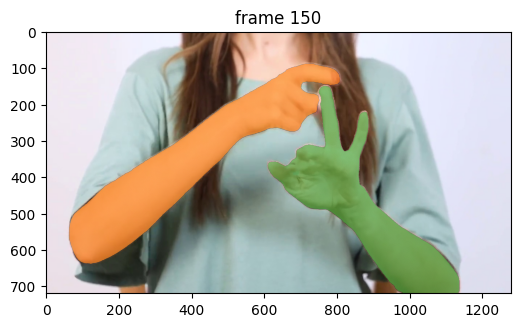

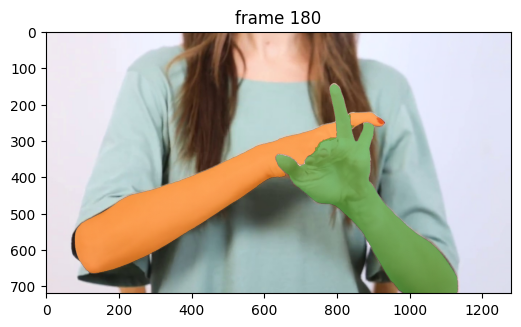

In [18]:
video_segments = {}
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

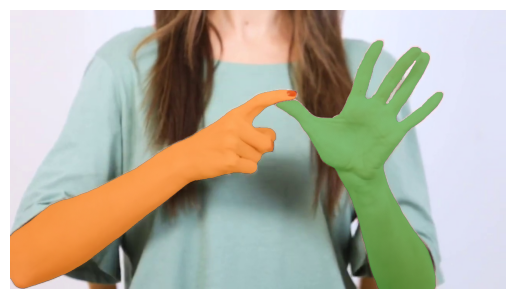

In [25]:
import io
from PIL import Image

for out_frame_idx in range(len(frame_names)):
    plt.clf()
    im = plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])), animated=True)
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)
    plt.axis('off')

    # Save to memory buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='jpeg', dpi=150, bbox_inches='tight', pad_inches=0)
    buf.seek(0)

    # Save from buffer to disk
    with open(f'/content/masks/{out_frame_idx:05d}.jpeg', 'wb') as f:
        f.write(buf.read())


In [26]:
!ffmpeg -framerate 30 -i /content/masks/%05d.jpeg -c:v libx264 -pix_fmt yuv420p /content/output_video.mp4

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab